# Initial Analysis

In [ ]:
# Setup
import pandas as pd
import numpy as np

file = "../ALSClusterAnalysis/als_data.csv"
df = pd.read_csv(file)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Columns: 101 entries, ID to Urine.Ph_min
dtypes: float64(75), int64(26)
memory usage: 1.7 MB


In [2]:
df.describe()


,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,...,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,...,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,1214.874944,54.550157,47.011134,43.952542,40.766347,0.013779,-0.728274,31.692308,27.104926,19.877193,...,136.755061,0.015000,498880.290148,6.203779,4.893387,2.955915,0.007136,6.820450,5.710639,5.183221
std,696.678300,11.396546,3.233980,2.654804,3.193087,0.009567,0.622329,5.314228,6.633643,8.583509,...,2.715247,0.009283,289923.528450,1.747660,2.146076,2.358095,0.004503,0.932141,0.625039,0.437222
min,1.000000,18.000000,37.000000,34.500000,24.000000,0.000000,-4.345238,11.000000,2.500000,0.000000,...,112.000000,0.000000,533.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,5.000000
25%,614.500000,47.000000,45.000000,42.000000,39.000000,0.009042,-1.086310,29.000000,23.000000,14.000000,...,135.000000,0.010582,240825.500000,5.000000,3.000000,1.000000,0.003643,6.000000,5.000000,5.000000
50%,1213.000000,55.000000,47.000000,44.000000,41.000000,0.012111,-0.620748,33.000000,28.000000,20.000000,...,137.000000,0.013123,496835.000000,7.000000,5.000000,3.000000,0.006920,7.000000,6.000000,5.000000
75%,1815.500000,63.000000,49.000000,46.000000,43.000000,0.015873,-0.283832,36.000000,32.000000,27.000000,...,138.000000,0.017278,750300.500000,8.000000,6.500000,5.000000,0.009639,7.000000,6.000000,5.000000
max,2424.000000,81.000000,70.300000,51.100000,49.000000,0.243902,1.207011,40.000000,40.000000,40.000000,...,145.000000,0.142857,999482.000000,8.000000,8.000000,8.000000,0.042017,9.000000,9.000000,8.000000


In [3]:
df.columns


Index(['ID', 'Age_mean', 'Albumin_max', 'Albumin_median', 'Albumin_min',
       'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_max',
       'ALSFRS_Total_median', 'ALSFRS_Total_min',
       ...
       'Sodium_min', 'Sodium_range', 'SubjectID', 'trunk_max', 'trunk_median',
       'trunk_min', 'trunk_range', 'Urine.Ph_max', 'Urine.Ph_median',
       'Urine.Ph_min'],
      dtype='object', length=101)

Very wide table with many specific records. Clustering should help simplify.

# Processing


In [4]:
# Step 1: Cleanup
# I'll drop some obviously irrelevant columns, and use some logic to hone in on the most pertinent features.
als_data = df.drop(columns=['ID', 'SubjectID'], errors='ignore')

# keep ALS-related columns. Assuming the three subjects are most relevant
als_data = als_data[[col for col in als_data.columns if 'ALSFRS' in col or 'Albumin' in col or 'Sodium' in col]]

# drop missing rows
als_data = als_data.dropna()

In [5]:
# Step 2: Standard scaler
from sklearn.preprocessing import StandardScaler

# init & fit
scaler = StandardScaler()
scaled_data = scaler.fit_transform(als_data)

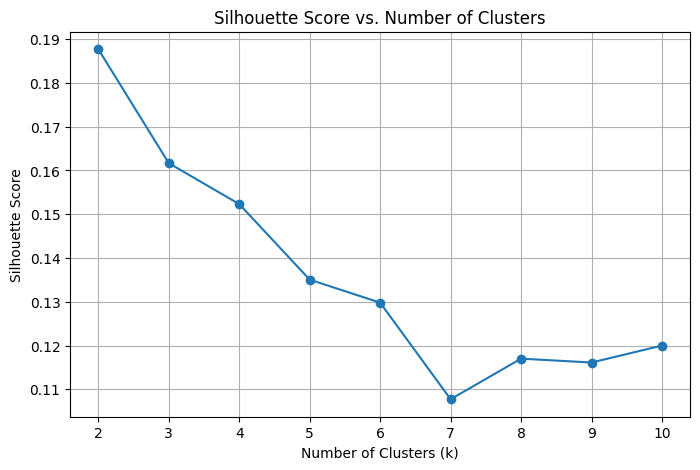

In [6]:
# Step 3: silhouette score vs. number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# init, then test 2-10 clusters
silhouette_scores = []
k_values = range(2, 11) 

# each cluster is labeled with silhouettes scored
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# plot silhouette
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


In [7]:
# Step 4: derive optimal number of clusters from max silhoeutte score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_k}')

# Step 5: fit K-means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Step 6: PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)


Optimal number of clusters: 2


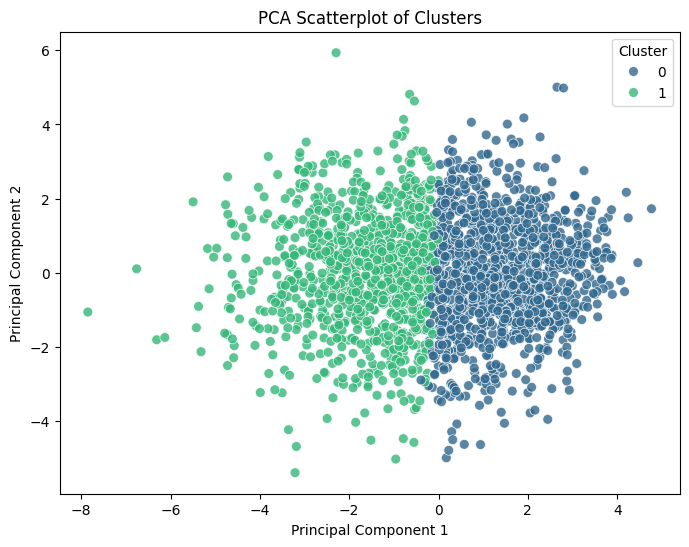

In [8]:
# Step 7: scatterplot PCA-transforms with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='viridis', s=50, alpha=0.8)
plt.title('PCA Scatterplot of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


                          PC1       PC2
Albumin_max          0.181320  0.531869
Albumin_median       0.235263  0.544975
Albumin_min          0.274533  0.466217
Albumin_range       -0.195748  0.069010
ALSFRS_slope         0.334525 -0.199209
ALSFRS_Total_max     0.337760 -0.084315
ALSFRS_Total_median  0.418554 -0.158637
ALSFRS_Total_min     0.472238 -0.225057
ALSFRS_Total_range  -0.386813  0.197618
Sodium_max           0.025779  0.120968
Sodium_median        0.029846  0.120770
Sodium_min           0.047621  0.075991
Sodium_range        -0.143026  0.036620


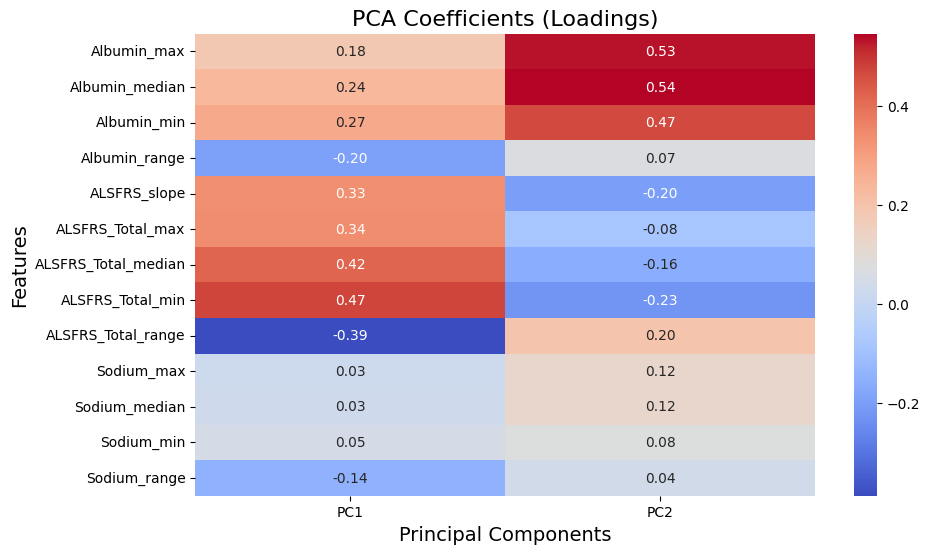

In [9]:
# Bonus: PCA components (I just wanted to understand this better)

# snag coefficents from each object and store in new df to visualize.
# each record lists feature then coefficents for each PCA.
coefficients = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=als_data.columns
)

# print & visualize coefficients
print(coefficients)
plt.figure(figsize=(10, 6))
sns.heatmap(coefficients, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Coefficients (Loadings)', fontsize=16)
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()


# Step 8: Summary
The 2 clusters are split upon ~ x=0.2. The first principal component is the most significant discriminator between the clusters. 
Per the PCA coefficients, ALSFRS features have dominant influence in the first PCA, and Albumin features dominate in the second. Since the cluster split occurs almost evenly along x=0.2, the influence of ALSFRS is clearly the distinguishing factor between clusters. Patients with lower ALSFRS scores (indicating lower functionality) are represented by the left cluster, and higher functionality patients are represented in the rigth cluster.
